# Settings, Imports, Util Functions

## Settings

In [1]:
model_type = 'untrained_resnet'

# model name, for tensorboard recording and checkpointing purposes.
versionName = "same opt imagewolf"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "6"

preload_model = False

if (preload_model):
    # path to load model params.
    pretrained_model_path = 'cps/a'
    
else:
    pretrained_model_path = 'N/A'

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# checkpoint rate. (save model every x epochs)
checkpoint_rate = 10

# number of epochs to train.
epochs = 10

## Imports

In [2]:
# --- Must haves ---
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import cuda

import pickle
import random
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from PIL import Image
from torchvision import transforms

## Util Functions

In [3]:
# --- Functions to convert between Torch Tensors and PIL Images
tensorToImage = torchvision.transforms.ToPILImage()
imageToTensor = torchvision.transforms.ToTensor()

# Datasets

## Dataset from Class

In [8]:
class Imagenette_Dataset(Dataset):
    
    def __init__(self, root_path, tfms=None):
        self.root_path = Path(root_path)
        self.tfms = tfms
        
        self.label_to_index = {label_path.name:i for i,label_path in enumerate(self.root_path.iterdir())}
        self.index_to_label = {i:label_path.name for i,label_path in enumerate(self.root_path.iterdir())}
        
        self.imgs = []
        for label_path in self.root_path.iterdir():
            self.imgs += list(label_path.iterdir())
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        label_name = trainDataset.imgs[idx].parent.name
        img = Image.open(trainDataset.imgs[idx]).convert('RGB')
        
        img = self.tfms(img)
        
        return img, self.label_to_index[label_name]

In [9]:
train_tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
trainDataset = Imagenette_Dataset('imagewoof2-320/train/', train_tfms)

valid_tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
validDataset = Imagenette_Dataset('imagewoof2-320/val/', valid_tfms)

len(trainDataset), len(validDataset)

(9025, 3929)

In [10]:
img, label = trainDataset[72]
label, img.shape

(0, torch.Size([3, 224, 224]))

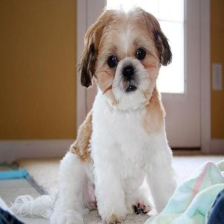

In [11]:
tensorToImage(img)

In [12]:
bs = 100
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bs, shuffle=True)
validDataLoader = DataLoader(dataset=validDataset, batch_size=bs)

# Model Setup

## Model Arch 1

In [13]:
def untrained_resnet():
    model = torchvision.models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(in_features=2048, out_features=10)
    model = model.cuda()
    return model

## Dispatch Model

In [14]:
dispatcher={'untrained_resnet':untrained_resnet}

In [15]:
def create_model():
    model = dispatcher[model_type]()
    if (preload_model):
        pretrained_model_params = torch.load(pretrained_model_path)
        print(model.load_state_dict(pretrained_model_params))
    return model

In [16]:
model = create_model()

## Parameters, Freezing/Unfreezing

In [17]:
def freezer():
    # --- Freeze Layer 1 and Layer 2 Parameters ---
    for param in model.named_parameters():
        if ('layer1' in param[0] or 'layer2' in param[0]):
            param[1].requires_grad = False
# freezer

In [18]:
layers_req_grad = 0
tot_layers = 0

params_req_grad = 0
tot_params = 0

for param in model.named_parameters():
    print(param[0])
    if (param[1].requires_grad):
        layers_req_grad += 1
        params_req_grad += param[1].nelement()
    tot_layers += 1
    tot_params += param[1].nelement()

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [19]:
print("{0:,} layers require gradients (unfrozen) out of {1:,} layers".format(layers_req_grad, tot_layers))
print("{0:,} parameters require gradients (unfrozen) out of {1:,} parameters".format(params_req_grad, tot_params))

161 layers require gradients (unfrozen) out of 161 layers
23,528,522 parameters require gradients (unfrozen) out of 23,528,522 parameters


## Loss Function

In [20]:
loss_func = torch.nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

## Forward Pass Playground

In [21]:
sampleBatch = next(iter(trainDataLoader))

In [22]:
with torch.no_grad():
    imgs = sampleBatch[0].cuda()
    labels = sampleBatch[1].cuda()
    preds = model(imgs)
    
preds.shape

torch.Size([100, 10])

In [23]:
labels.shape

torch.Size([100])

In [24]:
loss_func(preds, labels)

tensor(2.4415, device='cuda:0')

In [25]:
loss_func(preds, labels).item()

2.441471815109253

In [26]:
softedPreds = torch.softmax(preds,dim=1)
softedPreds.shape, softedPreds[0].sum()

(torch.Size([100, 10]), tensor(1., device='cuda:0'))

In [27]:
preds[0], softedPreds[0], labels[0]

(tensor([ 0.4112,  0.2652, -0.0854,  1.2555, -0.2345, -0.5563,  0.4013, -0.0233,
         -0.0778,  0.4301], device='cuda:0'),
 tensor([0.1114, 0.0963, 0.0678, 0.2592, 0.0584, 0.0424, 0.1103, 0.0722, 0.0683,
         0.1136], device='cuda:0'),
 tensor(6, device='cuda:0'))

In [28]:
# Top K accuracy.
k = 2
classPreds = softedPreds.topk(k=k, dim=1)[1]
print(labels)
print(classPreds[:5])

tensor([6, 8, 5, 2, 4, 6, 8, 6, 7, 3, 7, 9, 0, 3, 3, 1, 5, 3, 7, 0, 2, 0, 6, 0,
        7, 6, 9, 1, 2, 5, 5, 4, 5, 0, 3, 6, 7, 9, 5, 4, 1, 0, 9, 5, 5, 0, 9, 8,
        5, 4, 9, 0, 6, 3, 4, 3, 0, 8, 1, 9, 6, 7, 4, 5, 7, 9, 7, 5, 5, 4, 7, 8,
        1, 8, 4, 7, 9, 2, 1, 6, 3, 8, 9, 3, 0, 3, 8, 8, 6, 3, 8, 9, 7, 5, 9, 0,
        0, 3, 7, 4], device='cuda:0')
tensor([[3, 9],
        [3, 9],
        [3, 0],
        [3, 0],
        [3, 0]], device='cuda:0')


In [29]:
total_in_topK = 0
for i, x in enumerate(labels):
    if x in classPreds[i]:
        total_in_topK += 1

In [30]:
tot_num = len(labels)
total_in_topK, tot_num, total_in_topK/tot_num

(21, 100, 0.21)

# Train

## Utils

In [31]:
def calcTopK(preds, labels, k):
    softedPreds = torch.softmax(preds,dim=1)
    
    # Top K accuracy.
    classPreds = softedPreds.topk(k=k, dim=1)[1]
    
    total_in_topK = 0
    for i, x in enumerate(labels):
        if x in classPreds[i]:
            total_in_topK += 1

    tot_num = len(labels)
    
    return total_in_topK/tot_num

In [32]:
def writeMessage(msg):
    # Write to file.
    print(msg)
    myFile = open("Training Progress " + versionName + ".txt", "a")
    myFile.write(msg)
    myFile.write("\n")
    myFile.close()

## Training Epoch

In [33]:
def trainEpoch(myDataLoader):
    global tensorboard_recorder_train_step
    running_loss = 0.0
    running_top1 = 0.0
    running_top2 = 0.0
    running_top3 = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):
        
        # --- Main Training ---
        
        # gpu
        imgs = sampleBatch[0].cuda()
        labels = sampleBatch[1].cuda()
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward
        preds = model(imgs)
        
        # loss
        loss = loss_func(preds, labels)
        running_loss += loss.item()
        
        # backward
        loss.backward()
        
        # update parameters
        opt.step()
        
        # --- Metrics Recording ---
        
        # metrics
        top1 = calcTopK(preds, labels, k=1)
        top2 = calcTopK(preds, labels, k=2)
        top3 = calcTopK(preds, labels, k=3)
        running_top1 += top1
        running_top2 += top2
        running_top3 += top3
        
        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_train_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_top1 = running_top1/tensorboard_rate
            avg_running_top2 = running_top2/tensorboard_rate
            avg_running_top3 = running_top3/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Train Cross Entropy Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_train_step)
            tensorboard_writer.add_scalar(tag="Train Top-1 Accuracy", scalar_value=avg_running_top1, global_step=tensorboard_recorder_train_step)
            tensorboard_writer.add_scalar(tag="Train Top-2 Accuracy", scalar_value=avg_running_top2, global_step=tensorboard_recorder_train_step)
            tensorboard_writer.add_scalar(tag="Train Top-3 Accuracy", scalar_value=avg_running_top3, global_step=tensorboard_recorder_train_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_top1 = 0.0
            running_top2 = 0.0
            running_top3 = 0.0

## Valid Epoch

In [34]:
def validEpoch(myDataLoader):
    global tensorboard_recorder_valid_step
    running_loss = 0.0
    running_top1 = 0.0
    running_top2 = 0.0
    running_top3 = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):
        
        # --- Metrics Recording ---
        
        # gpu
        imgs = sampleBatch[0].cuda()
        labels = sampleBatch[1].cuda()

        # forward, no gradient calculations
        with torch.no_grad():
            preds = model(imgs)
        
        # loss
        loss = loss_func(preds, labels)
        running_loss += loss.item()
        
        # metrics
        top1 = calcTopK(preds, labels, k=1)
        top2 = calcTopK(preds, labels, k=2)
        top3 = calcTopK(preds, labels, k=3)
        running_top1 += top1
        running_top2 += top2
        running_top3 += top3
        
        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_valid_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_top1 = running_top1/tensorboard_rate
            avg_running_top2 = running_top2/tensorboard_rate
            avg_running_top3 = running_top3/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Valid Cross Entropy Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_valid_step)
            tensorboard_writer.add_scalar(tag="Valid Top-1 Accuracy", scalar_value=avg_running_top1, global_step=tensorboard_recorder_valid_step)
            tensorboard_writer.add_scalar(tag="Valid Top-2 Accuracy", scalar_value=avg_running_top2, global_step=tensorboard_recorder_valid_step)
            tensorboard_writer.add_scalar(tag="Valid Top-3 Accuracy", scalar_value=avg_running_top3, global_step=tensorboard_recorder_valid_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_top1 = 0.0
            running_top2 = 0.0
            running_top3 = 0.0

## Set-up and Main Loop

In [35]:
try:
    os.mkdir("cps")
except:
    print("checkpoints directory already exists :)")

In [36]:
from torch.utils.tensorboard import SummaryWriter
# create a summary writer.
tensorboard_writer = SummaryWriter("tensorboard_runs/model_" + versionName)

In [37]:
tensorboard_recorder_train_step = 0
tensorboard_recorder_valid_step = 0

In [38]:
def fit():
    writeMessage('---------- Started Training ----------')

    for epoch in range(1, epochs+1):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs))

        model.train()
        trainEpoch(trainDataLoader)

        model.eval()
        validEpoch(validDataLoader)
        
        if (epoch % checkpoint_rate == 0):
            torch.save(model.state_dict(), 'cps/model_'+versionName+'_epoch_'+str(epoch))

    writeMessage('---------- Finished Training ----------')

## Start Training

In [39]:
from torch_lr_finder import LRFinder

/home/saini5/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [40]:
opt = torch.optim.Adam(model.parameters(), lr=1e-7)
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-07
    weight_decay: 0
)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


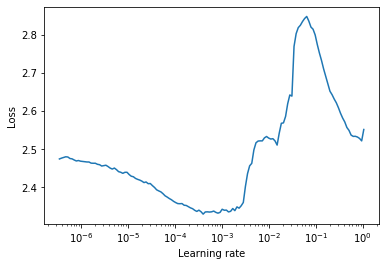

In [41]:
lr_finder = LRFinder(model=model, optimizer=opt, criterion=loss_func, device="cuda")
lr_finder.range_test(trainDataLoader, end_lr=100, num_iter=200)
lr_finder.plot()
# reset model & opt to their original weights
lr_finder.reset()

In [42]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

In [43]:
fit()

---------- Started Training ----------
--- Epoch 1/10 ---
--- Epoch 2/10 ---
--- Epoch 3/10 ---
--- Epoch 4/10 ---
--- Epoch 5/10 ---
--- Epoch 6/10 ---
--- Epoch 7/10 ---
--- Epoch 8/10 ---
--- Epoch 9/10 ---
--- Epoch 10/10 ---
---------- Finished Training ----------


In [44]:
opt.param_groups[0]['lr'] = 1e-7

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


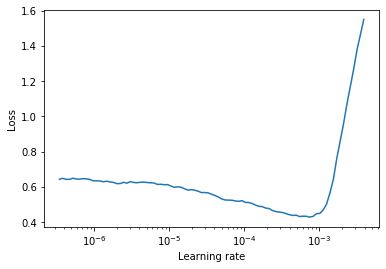

In [45]:
lr_finder = LRFinder(model=model, optimizer=opt, criterion=loss_func, device="cuda")
lr_finder.range_test(trainDataLoader, end_lr=100, num_iter=200)
lr_finder.plot()
# reset model & opt to their original weights
lr_finder.reset()

In [46]:
opt.param_groups[0]['lr'] = 3e-4

In [47]:
fit()

---------- Started Training ----------
--- Epoch 1/10 ---
--- Epoch 2/10 ---
--- Epoch 3/10 ---
--- Epoch 4/10 ---
--- Epoch 5/10 ---
--- Epoch 6/10 ---
--- Epoch 7/10 ---
--- Epoch 8/10 ---
--- Epoch 9/10 ---
--- Epoch 10/10 ---
---------- Finished Training ----------


In [48]:
opt.param_groups[0]['lr'] = 1e-7

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


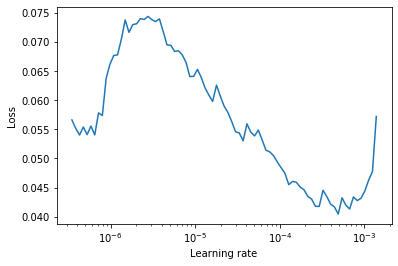

In [49]:
lr_finder = LRFinder(model=model, optimizer=opt, criterion=loss_func, device="cuda")
lr_finder.range_test(trainDataLoader, end_lr=100, num_iter=200)
lr_finder.plot()
# reset model & opt to their original weights
lr_finder.reset()

In [50]:
epochs = 5

In [51]:
opt.param_groups[0]['lr'] = 8e-5

In [52]:
fit()

---------- Started Training ----------
--- Epoch 1/5 ---
--- Epoch 2/5 ---
--- Epoch 3/5 ---
--- Epoch 4/5 ---
--- Epoch 5/5 ---
---------- Finished Training ----------


# Fin